In [ ]:
#github repository to use inbuilt function of pytorcg_grad_cam
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
# !pip install git+https://github.com/utkuozbulak/pytorch-cnn-visualizations.git
# !pip install git+https://github.com/frgfm/torch-cam.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-jwe3b_g1
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-jwe3b_g1
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 58a565a48fb3c28ac097f6a8533d554ac8ca2881
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=37426 sha256=951e91682d2d74232d8e7249da5eb47149cd6c1fd61d8eff422b7e5243122193
  Stored in directory: /tmp/pip-ephem-wheel-cache-m62653q1/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [ ]:
import cv2
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import models
import shutil
from PIL import Image
# from pytorch-gradcam import GradCAM, \
#     HiResCAM, \
#     ScoreCAM, \
#     GradCAMPlusPlus, \
#     AblationCAM, \
#     XGradCAM, \
#     EigenCAM, \
#     EigenGradCAM, \
#     LayerCAM, \
#     FullGrad, \
#     GradCAMElementWise
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM,LayerCAM
import skimage.io
import time
import os
import warnings
warnings.filterwarnings("ignore")
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from matplotlib import pyplot as plt

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50
# from torchvision.models import resnet18

# define the device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [ ]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

FileNotFoundError: ignored

In [ ]:
# transform = transforms.Compose(
#     [   transforms.Resize((128,128)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
#     ]
# )
# # test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR', train=False, download=True, transform=transform) #CIFAR10
# # test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # test_dataset = torchvision.datasets.Flowers102(root='./COCO', split='train', download=True, transform=transform) #Flowers102
# # test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# test_dataset = torchvision.datasets.STL10(root='./STL', split='train', download=True, transform=transform) #STL10
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # test_dataset = torchvision.datasets.OxfordIIITPet(root='./OxfordPet', split='trainval', download=True, transform=transform) #OxfordIIITPet
# # test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Files already downloaded and verified


In [ ]:
# classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #CIFAR10
classes=['airplane', 'bird', 'car', 'cat', 'deer', 'dog','horse', 'monkey', 'ship', 'truck'] #STL10
# classes=['American Bulldog','American Pit Bull Terrier','Basset Hound','Beagle','Boxer','Chihuahua','English Cocker Spaniel','English Setter','German Shorthaired','Great Pyreness','Havanese','Japanese Chin','Keeshond','Leonberger','Miniature Pinscher','Newfoundland','Pomeranian','Pug','Saint Bernard','Samyoed','Scottish Terrir','Shiba Inu','Staffordshire Bull Terrier','Wheaten Terrier','Yorkshire Terrier','Abyssinian','Bengal','Birman','Bombay','British Shorthair','Egyptian Mau','Main Coon','Persian','Ragdoll','Russian Blue','Siamese','Sphynx'] #OxfordIIITPet

In [ ]:
# classes= ['person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed','dining table','toilet','tv','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush'] #COCO

In [ ]:
# classes = [ 'pink primrose',
#  'hard-leaved pocket orchid',
#  'canterbury bells',
#  'sweet pea',
#  'english marigold',
#  'tiger lily',
#  'moon orchid',
#  'bird of paradise',
#  'monkshood',
#  'globe thistle',
#  'snapdragon',
#  "colt's foot",
#  'king protea',
#  'spear thistle',
#  'yellow iris',
#  'globe-flower',
#  'purple coneflower',
#  'peruvian lily',
#  'balloon flower',
#  'giant white arum lily',
#  'fire lily',
#  'pincushion flower',
#  'fritillary',
#  'red ginger',
#  'grape hyacinth',
#  'corn poppy',
#  'prince of wales feathers',
#  'stemless gentian',
#  'artichoke',
#  'sweet william',
#  'carnation',
#  'garden phlox',
#  'love in the mist',
#  'mexican aster',
#  'alpine sea holly',
#  'ruby-lipped cattleya',
#  'cape flower',
#  'great masterwort',
#  'siam tulip',
#  'lenten rose',
#  'barbeton daisy',
#  'daffodil',
#  'sword lily',
#  'poinsettia',
#  'bolero deep blue',
#  'wallflower',
#  'marigold',
#  'buttercup',
#  'oxeye daisy',
#  'common dandelion',
#  'petunia',
#  'wild pansy',
#  'primula',
#  'sunflower',
#  'pelargonium',
#  'bishop of llandaff',
#  'gaura',
#  'geranium',
#  'orange dahlia',
#  'pink-yellow dahlia?',
#  'cautleya spicata',
#  'japanese anemone',
#  'black-eyed susan',
#  'silverbush',
#  'californian poppy',
#  'osteospermum',
#  'spring crocus',
#  'bearded iris',
#  'windflower',
#  'tree poppy',
#  'gazania',
#  'azalea',
#  'rose',
#  'thorn apple',
#  'morning glory',
#  'passion flower',
#  'lotus',
#  'toad lily',
#  'anthurium',
#  'frangipani',
#  'clematis',
#  'hibiscus',
#  'columbine',
#  'desert-rose',
#  'tree mallow',
#  'magnolia',
#  'cyclamen ',
#  'watercress',
#  'canna lily',
#  'hippeastrum ',
#  'bee balm',
#  'ball moss',
#  'foxglove',
#  'bougainvillea',
#  'camellia',
#  'mallow',
#  'mexican petunia',
#  'bromelia',
#  'blanket flower',
#  'trumpet creeper',
#  'blackberry lily']

In [ ]:
len(classes)

10

In [ ]:
model = resnet50(pretrained=True)
# model = resnet18(pretrained=True)
# model.fc=nn.Linear(512,37) # OxfordIIITPet - Resnet18
# model.fc=nn.Linear(2048, 37) # OxfordIIITPet -  Resnet50
model.fc=nn.Linear(2048, 10)  #CIFAR10, STL10
# model.fc=nn.Linear(2048, 20) # Pascal VOC
# model.fc=nn.Linear(2048, 101) # MS COCO
# torch.save(model.load_state_dict, '/content/COCO/Flowers102_resnet50.pth')
# torch.save(model.load_state_dict, '/content/data/cifar10_resnet50.pth')
torch.save(model.load_state_dict, '/content/STL/STL10_resnet50.pth')
# torch.save(model.load_state_dict, '/content/CIFAR/CIFAR10_resnet50.pth')
# torch.save(model.load_state_dict, '/content/OxfordPet/OxfordPet_resnet50.pth')
# torch.save(model.load_state_dict, '/content/OxfordPet/OxfordPet_resnet18.pth')
model
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

correct prediction
prediction is  car
(128, 128, 3) -1.754760736716321e-08 0.9999999852895738


grad_cam (128, 128)
grad_cam (128, 128, 3)
grad_cam (128, 128)
uint8
uint8
grayscale_campp (128, 128)
grayscale_campp (128, 128)


100%|██████████| 64/64 [02:09<00:00,  2.03s/it]


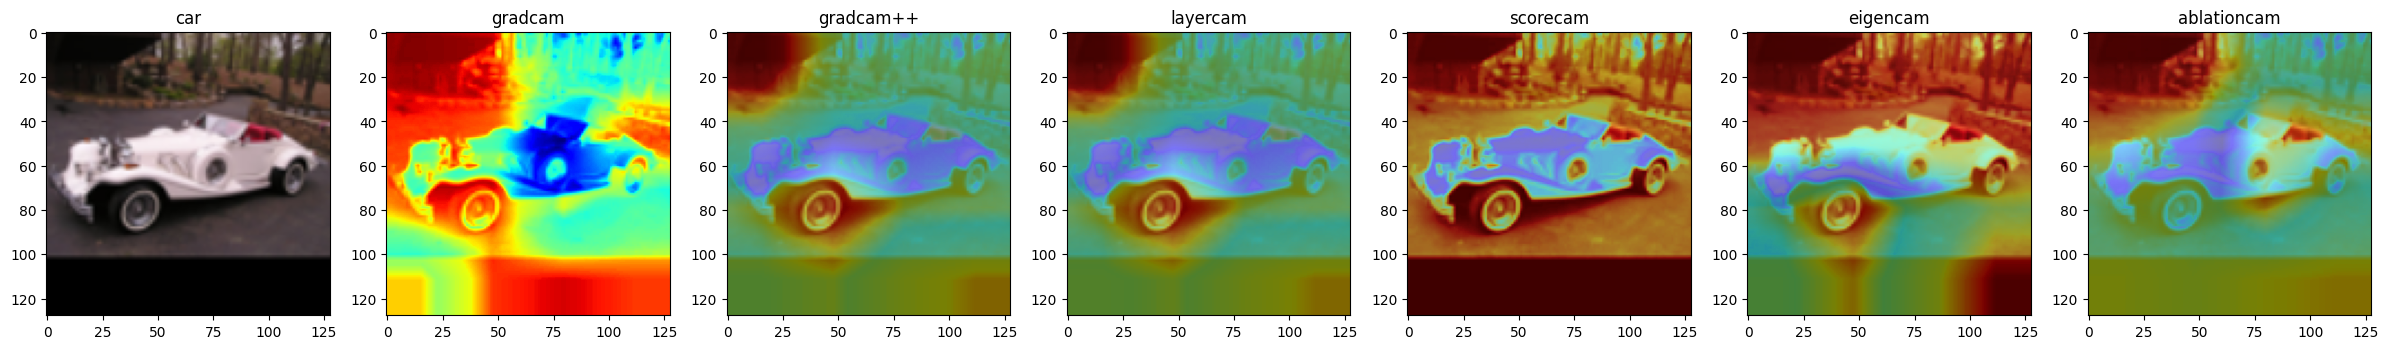

In [ ]:
target_layer = [model.layer4[-1]]
for i, (data, target) in enumerate(test_loader):
    if i>151:
        # print('entering')
        data, target = data.to(device), target.to(device)
        data= data.to(device)
        output= model(data)
        pred= output.argmax(dim=1, keepdim=True)
        if pred == target:
            print('correct prediction')
            print("prediction is ", classes[pred])
            fig, ax = plt.subplots(1,7, figsize=(30, 20))
            # fig, ax = plt.subplots(1,2, figsize=(30, 20))
            org_data= data.cpu().numpy().transpose((0, 2, 3, 1))[0]
            # cv2.imwrite('/content/STL/test_image.png', org_data)

            # denormalize
            org_data= org_data* np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
            org_data=cv2.resize(org_data, (128,128))
            print(org_data.shape, org_data.min(), org_data.max())
            # cv2.imwrite('/content/CIFAR/test_image.png', org_data)
            # cv2.imwrite('/content/COCO/test_image.png', org_data)
            # cv2.imwrite('/content/OxfordPet/test_image.png', org_data)
            cv2.imwrite('/content/STL/test_image.png', org_data)
            ax[0].imshow(org_data)
            ax[0].set_title(classes[pred])

            grad_cam = GradCAM(model=model, target_layers=target_layer, use_cuda=False)
            grayscale_cam = grad_cam(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            grayscale_cam = grayscale_cam[0, :]
            print('grad_cam', grayscale_cam.shape)
            visualization = show_cam_on_image(org_data, grayscale_cam)
            print('grad_cam', visualization.shape)
            # visualization= grayscale_cam
            visualization= cv2.resize(visualization, (128,128))
            visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
            print('grad_cam', visualization.shape)
            visualization = visualization*255
            print(visualization.dtype)
            visualization= visualization.astype(np.uint8)
            print(visualization.dtype)
            ax[1].imshow(visualization, cmap='jet')
            # ax[1].imshow(org_data, alpha=0.5)
            ax[1].set_title('gradcam')
            # cv2.imwrite('/content/COCO/grad_cam.png', visualization)
            # cv2.imwrite('/content/CIFAR/grad_cam.png', visualization)
            cv2.imwrite('/content/STL/grad_cam.png', visualization)
            # cv2.imwrite('/content/OxfordPet/grad_cam.png', visualization)

            # cbar = plt.colorbar(visualization,ax=ax[1])

            grad_campp= GradCAMPlusPlus(model=model, target_layers=target_layer, use_cuda=False)
            grayscale_campp = grad_campp(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            grayscale_campp = grayscale_campp[0, :]
            print('grayscale_campp', grayscale_campp.shape)
            visualization1 = show_cam_on_image(org_data, grayscale_campp)
            # grayscale_campp = cv2.resize(grayscale_campp, (224, 224))
            # visualization = show_cam_on_image(org_data, grayscale_campp)
            # visualization= grayscale_campp
            visualization1= cv2.resize(visualization1, (128,128))
            visualization1 = cv2.cvtColor(visualization1, cv2.COLOR_BGR2GRAY)
            print('grayscale_campp',visualization1.shape)
            visualization1 = visualization1*255
            visualization1= visualization1.astype(np.uint8)
            ax[2].imshow(visualization1, cmap='jet')
            ax[2].imshow(org_data, alpha=0.5)
            ax[2].set_title('gradcam++')
            # cv2.imwrite('/content/COCO/grad_campp.png', visualization)
            # cv2.imwrite('/content/CIFAR/grad_campp.png', visualization)
            cv2.imwrite('/content/STL/grad_campp.png', visualization1)
            # cv2.imwrite('/content/OxfordPet/grad_campp.png', visualization)

            layer_cam= LayerCAM(model=model, target_layers=target_layer, use_cuda=False)
            grayscale_layer_cam = layer_cam(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            grayscale_layer_cam = grayscale_layer_cam[0, :]
            visualization2 = show_cam_on_image(org_data, grayscale_layer_cam, use_rgb=False)
            # grayscale_layer_cam = cv2.resize(grayscale_layer_cam, (224, 224))
            # visualization = show_cam_on_image(org_data, grayscale_layer_cam)
            # visualization= grayscale_layer_cam
            visualization2= cv2.resize(visualization2, (128,128))
            visualization2 = cv2.cvtColor(visualization2, cv2.COLOR_BGR2GRAY)
            visualization2 = visualization2*255
            visualization2= visualization2.astype(np.uint8)
            ax[3].imshow(visualization2, cmap='jet')
            ax[3].imshow(org_data, alpha=0.5)
            ax[3].set_title('layercam')
            # visualization = cv2.cvtColor( visualization, cv2.COLOR_RGB2BGR)
            # cv2.imwrite('/content/COCO/layer_cam.png', visualization)
            # cv2.imwrite('/content/CIFAR/layer_cam.png', visualization)
            cv2.imwrite('/content/STL/layer_cam.png', visualization2)
            # cv2.imwrite('/content/OxfordPet/layer_cam.png', visualization)

            score_cam= ScoreCAM(model=model, target_layers=target_layer, use_cuda=False)
            grayscale_score_cam = score_cam(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            grayscale_score_cam = grayscale_score_cam[0, :]
            visualization = show_cam_on_image(org_data, grayscale_score_cam, use_rgb=False)
            # grayscale_score_cam = cv2.resize(grayscale_score_cam, (224, 224))
            # visualization = show_cam_on_image(org_data, grayscale_score_cam)
            # visualization= grayscale_score_cam
            visualization= cv2.resize(visualization, (128,128))
            visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
            visualization = visualization*255
            visualization= visualization.astype(np.uint8)
            ax[4].imshow(visualization, cmap='jet')
            ax[4].imshow(org_data, alpha=0.5)
            ax[4].set_title('scorecam')
            # visualization = cv2.cvtColor( visualization, cv2.COLOR_RGB2BGR)
            # cv2.imwrite('/content/COCO/score_cam.png', visualization)
            # cv2.imwrite('/content/CIFAR/score_cam.png', visualization)
            cv2.imwrite('/content/STL/score_cam.png', visualization)
            # cv2.imwrite('/content/OxfordPet/score_cam.png', visualization)

            eigen_cam= EigenCAM(model=model, target_layers=target_layer, use_cuda=False)
            grayscale_eigen_cam = eigen_cam(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            grayscale_eigen_cam = grayscale_eigen_cam[0, :]
            visualization = show_cam_on_image(org_data, grayscale_eigen_cam)
            # grayscale_ablation_cam = cv2.resize(grayscale_ablation_cam, (224, 224))
            # visualization = show_cam_on_image(org_data, grayscale_ablation_cam)
            # visualization= grayscale_eigen_cam
            visualization= cv2.resize(visualization, (128,128))
            visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
            visualization = visualization*255
            visualization= visualization.astype(np.uint8)
            ax[5].imshow(visualization, cmap='jet')
            ax[5].imshow(org_data, alpha=0.5)
            ax[5].set_title('eigencam')
            # visualization = cv2.cvtColor( visualization, cv2.COLOR_RGB2BGR)
            # cv2.imwrite('/content/COCO/eigen_cam.png', visualization)
            # cv2.imwrite('/content/CIFAR/eigen_cam.png', visualization)
            cv2.imwrite('/content/STL/eigen_cam.png', visualization)
            # cv2.imwrite('/content/OxfordPet/eigen_cam.png', visualization)

            ablation_cam= AblationCAM(model=model, target_layers=target_layer, use_cuda=False)
            grayscale_ablation_cam = ablation_cam(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            grayscale_ablation_cam = grayscale_ablation_cam[0, :]
            visualization = show_cam_on_image(org_data, grayscale_ablation_cam)
            # grayscale_ablation_cam = cv2.resize(grayscale_ablation_cam, (224, 224))
            # visualization = show_cam_on_image(org_data, grayscale_ablation_cam)
            # visualization= grayscale_ablation_cam
            visualization= cv2.resize(visualization, (128,128))
            visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
            visualization = visualization*255
            visualization= visualization.astype(np.uint8)
            ax[6].imshow(visualization, cmap='jet')
            ax[6].imshow(org_data, alpha=0.5)
            ax[6].set_title('ablationcam')
            # visualization = cv2.cvtColor( visualization, cv2.COLOR_RGB2BGR)
            # cv2.imwrite('/content/COCO/ablation_cam.png', visualization)
            # cv2.imwrite('/content/CIFAR/ablation_cam.png', visualization)
            cv2.imwrite('/content/STL/ablation_cam.png', visualization)
            # cv2.imwrite('/content/OxfordPet/ablation_cam.png', visualization)

            # score_cam= ScoreCAM(model=model, target_layers=target_layer, use_cuda=False)
            # grayscale_score_cam = score_cam(input_tensor=data, targets=[ClassifierOutputTarget(pred)])
            # grayscale_score_cam = grayscale_score_cam[0, :]
            # # visualization = show_cam_on_image(org_data, grayscale_cam, use_rgb=False)
            # # grayscale_score_cam = cv2.resize(grayscale_score_cam, (224, 224))
            # # visualization = show_cam_on_image(org_data, grayscale_score_cam)
            # visualization= grayscale_score_cam
            # visualization= cv2.resize(visualization, (128,128))
            # visualization = visualization*255
            # visualization= visualization.astype(np.uint8)
            # ax[7].imshow(visualization, cmap='jet')
            # ax[7].imshow(org_data, alpha=0.5)
            # ax[7].set_title('scorecam')
            # # visualization = cv2.cvtColor( visualization, cv2.COLOR_RGB2BGR)
            # # cv2.imwrite('/content/data/STL/score_cam.png', visualization)
            # # cv2.imwrite('/content/OxfordPet/score_cam1.png', visualization)
            # cv2.imwrite('/content/COCO/score_cam1.png', visualization)
            break

In [ ]:
#Used when we have to check CAM visualizations for images with given path

# # img_path ='/content/OxfordPet/oxford-iiit-pet/images/Bengal_2.jpg'
# # img_path='/content/STL/test_image.png'
# # img_path='/content/CIFAR/test_image.png'
# img_path = '/content/COCO/flowers-102/jpg/image_00150.jpg'
# test_image = Image.open(img_path).convert('RGB')
# # test_image=org_data
# imgplot = plt.imshow(test_image)
# plt.show()

# toTensor =  transforms.Compose([
#                 transforms.Resize((100,100)),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ])
# input_tensor = toTensor(test_image)

# test_image = np.array(test_image)
# test_image = cv2.resize(test_image,(100,100))
# test_image = test_image.astype('float32')
# test_image /= 255.0

# fig, ax = plt.subplots(1,7, figsize=(20, 10))
# ax[0].imshow(test_image)
# # plt.show()
# ax[0].set_title('Input')


# target_layer = [model.layer4[-1]]
# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layer, use_cuda= False)
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=None)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(test_image, grayscale_cam)
# ax[1].imshow(visualization)
# ax[1].set_title('Gradcam')
# visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
# # cv2.imwrite('/content/OxfordPet/grad_cam1.png', visualization)
# # cv2.imwrite('/content/STL/grad_cam1.png', visualization)
# # cv2.imwrite('/content/CIFAR/grad_cam1.png', visualization)
# cv2.imwrite('/content/COCO/grad_cam1.png', visualization)
# # plt.show()

# cam = GradCAMPlusPlus(model=model, target_layers=target_layer, use_cuda= False)
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=None)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(test_image, grayscale_cam)
# ax[2].imshow(visualization)
# ax[2].set_title('Gradcam++')
# visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
# # cv2.imwrite('/content/OxfordPet/grad_campp1.png', visualization)
# # cv2.imwrite('/content/STL/grad_campp1.png', visualization)
# # cv2.imwrite('/content/CIFAR/grad_campp1.png', visualization)
# cv2.imwrite('/content/COCO/grad_campp1.png', visualization)
# # plt.show()


# cam = ScoreCAM(model=model, target_layers=target_layer, use_cuda= False)
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=None)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(test_image, grayscale_cam)
# ax[3].imshow(visualization)
# ax[3].set_title('Scorecam')
# visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
# # cv2.imwrite('/content/OxfordPet/score_cam1.png', visualization)
# # cv2.imwrite('/content/STL/score_cam1.png', visualization)
# # cv2.imwrite('/content/CIFAR/score_cam1.png', visualization)
# cv2.imwrite('/content/COCO/score_cam1.png', visualization)
# # plt.show()

# cam = AblationCAM(model=model, target_layers=target_layer, use_cuda= False)
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=None)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(test_image, grayscale_cam)
# ax[4].imshow(visualization)
# ax[4].set_title('Ablationcam')
# visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
# # cv2.imwrite('/content/OxfordPet/ablation_cam1.png', visualization)
# # cv2.imwrite('/content/STL/ablation_cam1.png', visualization)
# # cv2.imwrite('/content/CIFAR/ablation_cam1.png', visualization)
# cv2.imwrite('/content/COCO/ablation_cam1.png', visualization)
# # plt.show()

# cam = EigenCAM(model=model, target_layers=target_layer, use_cuda= False)
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=None)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(test_image, grayscale_cam)
# ax[5].imshow(visualization)
# ax[5].set_title('Eigencam')
# visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
# # cv2.imwrite('/content/OxfordPet/eigen_cam1.png', visualization)
# # cv2.imwrite('/content/STL/eigen_cam1.png', visualization)
# # cv2.imwrite('/content/CIFAR/eigen_cam1.png', visualization)
# cv2.imwrite('/content/COCO/eigen_cam1.png', visualization)
# # plt.show()

# cam = LayerCAM(model=model, target_layers=target_layer, use_cuda= False)
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=None)
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(test_image, grayscale_cam)
# ax[6].imshow(visualization)
# ax[6].set_title('Layercam')
# visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2GRAY)
# # cv2.imwrite('/content/OxfordPet/layer_cam1.png', visualization)
# # cv2.imwrite('/content/STL/layer_cam1.png', visualization)
# # cv2.imwrite('/content/CIFAR/layer_cam1.png', visualization)
# cv2.imwrite('/content/COCO/layer_cam1.png', visualization)

In [ ]:
# import nibabel as nib # https://nipy.org/nibabel/
!pip install SimpleITK
import SimpleITK as sitk # https://simpleitk.org/
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(128, 128) (128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(128, 128) (128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(128, 128) (128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(128, 128)
(128, 128)


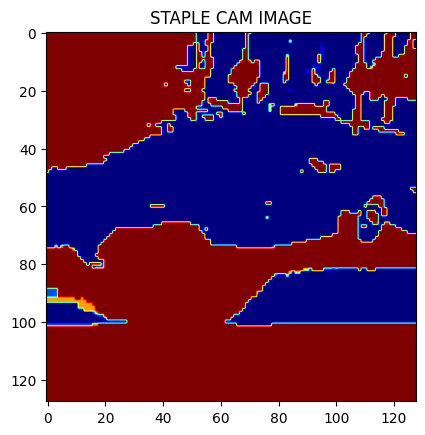

In [ ]:
# STAPLE CAM code
# img1=skimage.io.imread('/content/data/grad_cam.png')/255
# img2=skimage.io.imread('/content/data/grad_campp.png')/255
# img3=skimage.io.imread('/content/data/layer_cam.png')/255
# img4=skimage.io.imread('/content/data/score_cam.png')/255
# img5=skimage.io.imread('/content/data/ablation_cam.png')/255

img1=skimage.io.imread('/content/STL/grad_cam.png')/255
img2=skimage.io.imread('/content/STL/grad_campp.png')/255
img3=skimage.io.imread('/content/STL/layer_cam.png')/255
img4=skimage.io.imread('/content/STL/score_cam.png')/255
img5=skimage.io.imread('/content/STL/ablation_cam.png')/255
img6=skimage.io.imread('/content/STL/eigen_cam.png')/255

# img1=skimage.io.imread('/content/CIFAR/grad_cam.png')/255
# img2=skimage.io.imread('/content/CIFAR/grad_campp.png')/255
# img3=skimage.io.imread('/content/CIFAR/layer_cam.png')/255
# img4=skimage.io.imread('/content/CIFAR/score_cam.png')/255
# img5=skimage.io.imread('/content/CIFAR/ablation_cam.png')/255
# img6=skimage.io.imread('/content/CIFAR/eigen_cam.png')/255

# img1=skimage.io.imread('/content/OxfordPet/grad_cam.png')/255
# img2=skimage.io.imread('/content/OxfordPet/grad_campp.png')/255
# img3=skimage.io.imread('/content/OxfordPet/layer_cam.png')/255
# img4=skimage.io.imread('/content/OxfordPet/eigen_cam.png')/255
# img5=skimage.io.imread('/content/OxfordPet/ablation_cam.png')/255
# img6=skimage.io.imread('/content/OxfordPet/score_cam.png')/255

# img1=skimage.io.imread('/content/OxfordPet/grad_cam1.png')/255
# img2=skimage.io.imread('/content/OxfordPet/grad_campp1.png')/255
# img3=skimage.io.imread('/content/OxfordPet/layer_cam1.png')/255
# img4=skimage.io.imread('/content/OxfordPet/eigen_cam1.png')/255
# img5=skimage.io.imread('/content/OxfordPet/ablation_cam1.png')/255
# img6=skimage.io.imread('/content/OxfordPet/score_cam1.png')/255

# img1=skimage.io.imread('/content/COCO/grad_cam.png')/255
# img2=skimage.io.imread('/content/COCO/grad_campp.png')/255
# img3=skimage.io.imread('/content/COCO/layer_cam.png')/255
# img4=skimage.io.imread('/content/COCO/score_cam.png')/255
# img5=skimage.io.imread('/content/COCO/ablation_cam.png')/255
# img6=skimage.io.imread('/content/COCO/eigen_cam.png')/255

# img1=skimage.io.imread('/content/COCO/grad_cam1.png')/255
# img2=skimage.io.imread('/content/COCO/grad_campp1.png')/255
# img3=skimage.io.imread('/content/COCO/layer_cam1.png')/255
# img4=skimage.io.imread('/content/COCO/score_cam1.png')/255
# img5=skimage.io.imread('/content/COCO/ablation_cam1.png')/255
# img6=skimage.io.imread('/content/COCO/eigen_cam1.png')/255

# print(img1.shape, img2.shape, img3.shape, img4.shape, img5.shape)
print(img1.shape, img2.shape, img3.shape, img4.shape, img5.shape, img6.shape)
img1[img1<0.5]=0
img1[img1>=0.5]=1
img2[img2<0.5]=0
img2[img2>=0.5]=1
img3[img3<0.5]=0
img3[img3>=0.5]=1
img4[img4<0.5]=0
img4[img4>=0.5]=1
img5[img5<0.5]=0
img5[img5>=0.5]=1
img6[img6<0.5]=0
img6[img6>=0.5]=1

print(img1.shape, img2.shape, img3.shape, img4.shape, img5.shape, img6.shape)
seg1=sitk.GetImageFromArray(img1.astype(np.int16))
seg2=sitk.GetImageFromArray(img2.astype(np.int16))
seg3=sitk.GetImageFromArray(img3.astype(np.int16))
seg4=sitk.GetImageFromArray(img4.astype(np.int16))
seg5=sitk.GetImageFromArray(img5.astype(np.int16))
seg6=sitk.GetImageFromArray(img6.astype(np.int16))
print(img1.shape, img2.shape, img3.shape, img4.shape, img5.shape, img6.shape)
# size = seg1.GetSize()
# print(size)
# # Iterate over all the pixels
# for y in range(size[1]):
#     for x in range(size[0]):
#         # Get the pixel value at the current coordinates
#         pixel_value = seg1.GetPixel(x, y)

#         # Print the pixel value
#         print(f"Pixel value at ({x}, {y}): {pixel_value}")

# seg_stack=[seg1, seg2, seg3, seg4, seg5]
seg_stack=[ seg1, seg2, seg3, seg4, seg5,seg6]
STAPLE_seg_sitk = sitk.STAPLE(seg_stack, 1 ) # 1.0 specifies the foreground value
STAPLE_seg = sitk.GetArrayFromImage(STAPLE_seg_sitk)
print(STAPLE_seg.shape)
# STAPLE_seg= STAPLE_seg.astype(np.uint8)
STAPLE_seg= STAPLE_seg*255
STAPLE_seg= STAPLE_seg.astype(np.uint8)
# STAPLE_seg = cv2.cvtColor(STAPLE_seg, cv2.COLOR_GRAY2BGR)
print(STAPLE_seg.shape)
# print(org_data.shape)
org_data =cv2.resize(org_data,(100,100))
# print(org_data.shape)
# cv2.imwrite('/content/STL/STAPLE_seg.png', STAPLE_seg)
# cv2.imwrite('/content/OxfordPet/STAPLE_seg.png', STAPLE_seg)
# fig, ax = plt.subplots(1,2, figsize=(20, 10))
plt.imshow(STAPLE_seg,'jet')
plt.title('STAPLE CAM IMAGE')
# ax[0].set_title("STAPLE CAM")
# plt.imshow(org_data, alpha=0.5)
# ax[1].imshow('Original Image')
plt.show()

(128, 128)


Text(0.5, 1.0, 'STAPLECAM Superimposed Heatmap')

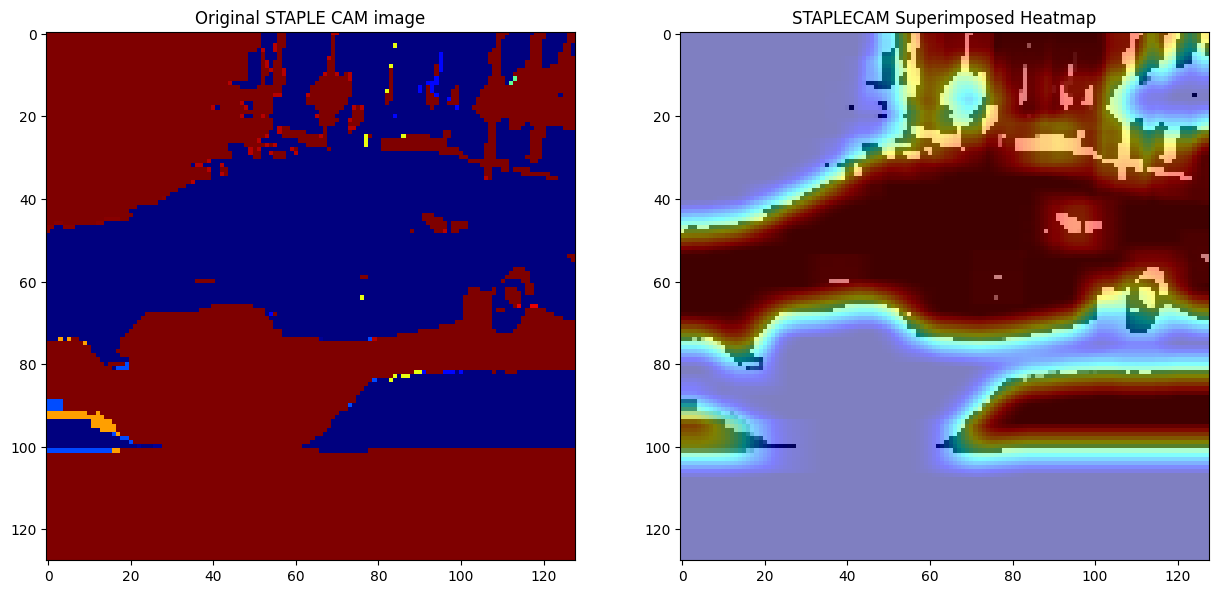

In [ ]:
#Apply heatmap

# fig, ax = plt.subplots(1,5, figsize=(20, 10))
# print(STAPLE_seg.shape)
# ax[0].imshow(STAPLE_seg,'jet')
# ax[0].set_title('Original STAPLE CAM image')
# img=cv2.cvtColor(STAPLE_seg, cv2.COLOR_GRAY2BGR)
# print(img.shape)
# ax[1].imshow(img)
# ax[1].set_title('Change image')
# # lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
# # a_component = lab[:,:,1]
# # th = cv2.threshold(a_component,140,255,cv2.THRESH_BINARY)[1]
# # ax[2].imshow(th)
# # ax[2].set_title('binary image')
# # blur = cv2.GaussianBlur(th,(13,13), 11)
# blur = cv2.GaussianBlur(img,(13,13), 11)
# ax[2].imshow(blur)
# ax[2].set_title('Gaussian Blur')
# heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
# ax[3].imshow(heatmap_img)
# ax[3].set_title('Heatmap')
# super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
# ax[4].imshow(super_imposed_img)
# ax[4].set_title('STAPLECAM Superimposed Heatmap')

fig, ax = plt.subplots(1,2, figsize=(15, 8))
print(STAPLE_seg.shape)
ax[0].imshow(STAPLE_seg,'jet')
ax[0].set_title('Original STAPLE CAM image')
img=cv2.cvtColor(STAPLE_seg, cv2.COLOR_GRAY2BGR)
blur = cv2.GaussianBlur(img,(13,13), 11)
heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
ax[1].imshow(super_imposed_img)
ax[1].set_title('STAPLECAM Superimposed Heatmap')

In [ ]:
# !git clone git://github.com/fepegar/staple
!pip install git+https://github.com/fepegar/staple.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fepegar/staple.git to /tmp/pip-req-build-wi4nqql1
  Running command git clone --filter=blob:none --quiet https://github.com/fepegar/staple.git /tmp/pip-req-build-wi4nqql1
  Resolved https://github.com/fepegar/staple.git to commit eac0dddd3baed1c04eb4e13337cd1c6ff94fade9
  Preparing metadata (setup.py) ... done
  Using cached SimpleITK-1.2.0.tar.gz (2.0 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# # -*- coding: utf-8 -*-

# """Console script for staple."""
# import sys
# import click


# @click.command()
# @click.argument('input_files', nargs=-1, type=click.Path(exists=True))
# @click.argument('output_file', nargs=1, type=click.Path())
# @click.option('--verbose/--no-verbose', default=False)
# @click.option('--binarize/--probabilities', default=True)
# @click.option('--convergence-threshold')
# def main(input_files, output_file, verbose, binarize, convergence_threshold):
#     """Run STAPLE algorithm on a set of binary expert segmentations."""
#     from staple import run_staple
#     run_staple(
#         input_files,
#         output_file,
#         verbose,
#         binarize,
#         convergence_threshold,
#     )
#     return 0


# # if __name__ == "__main__":
# #     # sys.exit(main())  # pragma: no cover
# #     main()  # pragma: no cover

In [ ]:
from numpy.ma.core import diff
# -*- coding: utf-8 -*-

"""Main module."""

from enum import Enum
from pathlib import Path
from typing import List, Optional, Union

import numpy as np
import SimpleITK as sitk


__all__ = ['run_staple', 'STAPLE']


class Convergence(Enum):
    itk = 'itk'
    warfield = 'warfield'


class STAPLE:
    def __init__(
            self,
            arrays: List[np.ndarray],
            maximization_first: bool = True,
            convergence_type: Convergence = Convergence.warfield,
            sensitivity_init: float = 0.99999,
            specificity_init: float = 0.99999,
            max_num_iterations: int = 50,
            verbose: bool = False,
            convergence_threshold: Optional[float] = None,
            ):
        if not arrays:
            raise ValueError('arrays must be a list of NumPy arrays')
        self.arrays = arrays
        self.decisions_matrix = self._get_decisions_matrix(arrays)  # D
        self.maximization_first = maximization_first
        self.convergence_type = convergence_type
        self.num_voxels, self.num_raters = self.decisions_matrix.shape  # N, R
        self.sensitivity_init = sensitivity_init
        self.specificity_init = specificity_init
        self.sensitivity = None  # p
        self.specificity = None  # q
        self.output = None  # W
        self.prior = self._get_prior(self.decisions_matrix)
        self.max_num_iterations = max_num_iterations
        self.verbose = verbose
        if convergence_threshold is None:
            convergence_threshold = 1e-3
            # convergence_threshold = 1e-7
        self.convergence_threshold = convergence_threshold
        self._init()

    @staticmethod
    def _get_decisions_matrix(arrays) -> np.ndarray:
        columns = [array.flatten() for array in arrays]
        decisions_matrix = np.column_stack(columns)
        print('decision matrix :',decisions_matrix)
        return decisions_matrix

    @staticmethod
    def _get_prior(decisions_matrix) -> float:
        gamma = decisions_matrix.mean()
        return gamma

    @staticmethod
    def _to_column(array):
        return array.reshape(-1, 1) #convert array to column

    @staticmethod
    def _to_row(array):
        return array.reshape(1, -1)  #convert array to row

    def _init(self) -> None:
        if self.maximization_first:
            self.output = np.array(self.arrays).mean(axis=0)
            self.output = self._to_column(self.output)
            self.output = self.output.astype(np.float64)
        else:
            shape = (1, self.num_raters)
            self.sensitivity = np.full(shape, self.sensitivity_init)
            self.sensitivity = self.sensitivity.astype(np.float64)
            self.specificity = np.full(shape, self.specificity_init)
            self.specificity = self.specificity.astype(np.float64)
        self.previous_sum = -1
        self.num_iterations = 1

    def _run_expectation(self) -> None:
        p = self.sensitivity
        q = self.specificity
        D = self.decisions_matrix
        N = self.num_voxels #number of voxels
        f_1 = self.prior #Prior probability of Ti=1
        f_0 = 1 - f_1   #Prior probability of Ti=0

        # Compute a
        p_matrix = p.repeat(N, axis=0)
        p1_matrix = 1 - p_matrix
        # m_1 = np.ma.masked_array(p_matrix, D == 1).prod(axis=1)  # second term
        # m_2 = np.ma.masked_array(p1_matrix, D ==0).prod(axis=1)  # third term
        m_1 = np.ma.masked_array(p_matrix, D == 0).prod(axis=1)  # second term
        m_2 = np.ma.masked_array(p1_matrix, D ==1).prod(axis=1)  # third term
        a = f_1 * m_1.data * m_2.data #equation 14

        # Compute b
        q_matrix = q.repeat(N, axis=0)
        q1_matrix = 1 - q_matrix
        # m_1 = np.ma.masked_array(q_matrix, D == 0).prod(axis=1)  # second term
        # m_2 = np.ma.masked_array(q1_matrix, D == 1).prod(axis=1)  # third term
        m_1 = np.ma.masked_array(q_matrix, D == 1).prod(axis=1)  # second term
        m_2 = np.ma.masked_array(q1_matrix, D == 0).prod(axis=1)  # third term
        b = f_0 * m_1.data * m_2.data #equation 15

        # Compute W
        W = a / (a + b)  #equation 16
        W = self._to_column(W)
        self.output = W
        # print(a,b,W)

    def _run_maximization(self) -> None:
        w_1 = self.output
        w_0 = 1 - w_1
        R = self.num_raters
        D = self.decisions_matrix

        w_1_matrix = w_1.repeat(R, axis=1)
        # num = np.ma.masked_array(w_1_matrix, D == 1).sum(axis=0).data # D==1 should be there Equation 18
        num = np.ma.masked_array(w_1_matrix, D == 0).sum(axis=0).data # D==1 should be there Equation 18
        denom = w_1.sum()
        p = num / denom
        p = self._to_row(p)

        w_0_matrix = w_0.repeat(R, axis=1)
        # num = np.ma.masked_array(w_0_matrix, D == 0).sum(axis=0).data # D==0 should be there Equation 19
        num = np.ma.masked_array(w_0_matrix, D == 1).sum(axis=0).data # D==0 should be there Equation 19
        denom = w_0.sum()
        q = num / denom
        q = self._to_row(q)

        self.sensitivity = p
        self.specificity = q

        if self.verbose:
            print('Sensitivities:', p.ravel())
            print('Specificities:', q.ravel())

    def _run_iteration(self) -> None:
        step_1, step_2 = self._run_expectation, self._run_maximization
        if self.maximization_first:
            step_1, step_2 = step_2, step_1
        step_1()
        step_2()
        self.num_iterations += 1

    def _check_convergence(self) -> bool:
        if self.convergence_type == Convergence.warfield:
            current_sum = self.output.sum()
            diff = abs(current_sum - self.previous_sum)
            if self.verbose:
                print('Sum difference:', diff)
            self.previous_sum = current_sum
            return diff <= self.convergence_threshold
        else:
            raise NotImplementedError
        print('number of iterations:',self.num_iterations,'diff :',diff)

    def run(self) -> Optional[np.ndarray]:
        while True:
            if self.verbose:
                print('Running iteration', self.num_iterations)
            self._run_iteration()
            if self._check_convergence():
                success = True
                break
            elif self.num_iterations == self.max_num_iterations:
                success = False
                break
            if self.verbose:
                print()
        if success:
            if self.verbose:
                print('\n\nConvergence reached after',
                      self.num_iterations, 'iterations')
            one_shape = self.arrays[0].shape
            return self.output.reshape(one_shape)
        else:
            message = 'Maximum number of iterations reached before convergence'
            raise ValueError(message)


def get_images(filepaths: List[Union[str, Path]]) -> List[sitk.Image]:
    images = [sitk.ReadImage(str(path)) for path in filepaths]
    return images


def run_staple(
        input_files,
        verbose,
        binarize,
        convergence_threshold,
        ):
    images = get_images(input_files)
    print(len(images))
    arrays = [sitk.GetArrayFromImage(image) for image in images]
    print(arrays)
    staple = STAPLE(
        arrays,
        verbose=verbose,
        convergence_threshold=convergence_threshold,
    )
    output_array = staple.run()
    print('Output Array :',output_array)
    print('Sensitivities: {}'.format(staple.sensitivity.flatten()))
    print('Specificities: {}'.format(staple.specificity.flatten()))
    output_image = sitk.GetImageFromArray(output_array)
    if binarize:
        output_image = sitk.BinaryThreshold(output_image, 0.5)
        # print("Hi")
    print('Output Array shape :',output_image.GetSize())
    reference_image = images[0]
    fig, ax = plt.subplots(1,2, figsize=(20, 10))
    slice = sitk.GetArrayViewFromImage(reference_image)
    ax[0].imshow(slice,cmap='jet')
    ax[0].set_title('Input Image')
    slice1 = sitk.GetArrayViewFromImage(output_image)
    ax[1].imshow(slice1,cmap='hsv')
    ax[1].set_title('STAPLE Image')
    # cv2.imwrite('/content/STL/STAPLE_seg_final.png', reference_image)
    # cv2.resize(reference_image,(128,128))
    # img=output_image.save('/content/STL/STAPLE_seg_final.png')
    # output_image = output_image.resize((128,128))
    # plt.imshow(output_image, cmap='jet')
    # plt.imshow(org_data, alpha=0.5)
    # plt.show()
    # output_image.SetSpacing(reference_image.GetSpacing())
    # output_image.SetOrigin(reference_image.GetOrigin())
    # output_image.SetDirection(reference_image.GetDirection())
    # sitk.WriteImage(output_image, output_file)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""Tests for `staple` package."""

import pytest

from click.testing import CliRunner

# from staple import staple
# from staple import cli


def download_images(force_download=False):
    """
    From https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/34_Segmentation_Evaluation.ipynb
    """
    import tempfile
    import urllib.request
    from pathlib import Path

    filepaths = []
    # filepaths.append('/content/OxfordPet/grad_cam.png')
    # filepaths.append('/content/OxfordPet/grad_campp.png')
    # filepaths.append('/content/OxfordPet/layer_cam.png')
    # filepaths.append('/content/OxfordPet/score_cam.png')
    # filepaths.append('/content/OxfordPet/ablation_cam.png')
    # filepaths.append('/content/OxfordPet/eigen_cam.png')
    filepaths.append('/content/STL/grad_cam.png')
    filepaths.append('/content/STL/grad_campp.png')
    filepaths.append('/content/STL/layer_cam.png')
    filepaths.append('/content/STL/score_cam.png')
    filepaths.append('/content/STL/ablation_cam.png')
    filepaths.append('/content/STL/eigen_cam.png')
    # filepaths.append('/content/CIFAR/grad_cam.png')
    # filepaths.append('/content/CIFAR/grad_campp.png')
    # filepaths.append('/content/CIFAR/layer_cam.png')
    # filepaths.append('/content/CIFAR/score_cam.png')
    # filepaths.append('/content/CIFAR/ablation_cam.png')
    # filepaths.append('/content/CIFAR/eigen_cam.png')
    # filepaths.append('/content/COCO/grad_cam.png')
    # filepaths.append('/content/COCO/grad_campp.png')
    # filepaths.append('/content/COCO/layer_cam.png')
    # filepaths.append('/content/COCO/score_cam.png')
    # filepaths.append('/content/COCO/ablation_cam.png')
    # filepaths.append('/content/COCO/eigen_cam.png')
    # print(filepaths)
    return filepaths

def get_real_arrays():
    """
    From https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/34_Segmentation_Evaluation.ipynb
    """
    from pathlib import Path
    import SimpleITK as sitk
    arrays = []
    filepaths = download_images()
    for filepath in filepaths:
        image = sitk.ReadImage(str(filepath), sitk.sitkUInt8)
        array = sitk.GetArrayFromImage(image)
        arrays.append(array)
    return arrays


@pytest.fixture
def probabilities_real():
    import SimpleITK as sitk
    arrays = get_real_arrays()
    images = [sitk.GetImageFromArray(array) for array in arrays]
    staple_result = sitk.STAPLE(images)
    result = sitk.GetArrayFromImage(staple_result)
    return result


# def test_staple_real(probabilities_real):
#     import numpy as np
#     arrays = get_real_arrays()
#     s = staple.STAPLE(arrays, convergence_threshold=0)
#     result = s.run()
#     np.testing.assert_almost_equal(result, probabilities_real)


# download_images()
# actual_result= probabilities_real()
# test_staple_real(actual_result)
# test_staple_real(probabilities_real)

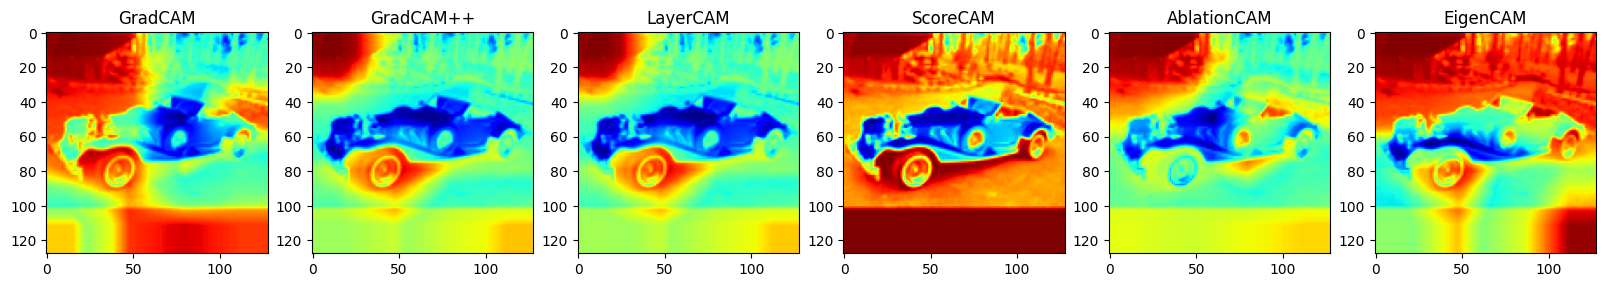

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(20, 10))
# test_image = Image.open('/content/CIFAR/test_image.png')
# ax[0].imshow(test_image,'jet')
# ax[0].set_title('Input Image')
test_image = Image.open('/content/STL/grad_cam.png')
# test_image = Image.open('/content/COCO/grad_cam.png')
# test_image = Image.open('/content/COCO/grad_cam1.png')
# test_image = Image.open('/content/OxfordPet/grad_cam.png')
ax[0].imshow(test_image,'jet')
ax[0].set_title('GradCAM')
test_image = Image.open('/content/STL/grad_campp.png')
# test_image = Image.open('/content/COCO/grad_campp.png')
# test_image = Image.open('/content/COCO/grad_campp1.png')
# test_image = Image.open('/content/OxfordPet/grad_campp.png')
ax[1].imshow(test_image,'jet')
ax[1].set_title('GradCAM++')
test_image = Image.open('/content/STL/layer_cam.png')
# test_image = Image.open('/content/COCO/layer_cam.png')
# test_image = Image.open('/content/COCO/layer_cam1.png')
# test_image = Image.open('/content/OxfordPet/layer_cam.png')
ax[2].imshow(test_image,'jet')
ax[2].set_title('LayerCAM')
test_image = Image.open('/content/STL/score_cam.png')
# test_image = Image.open('/content/COCO/score_cam.png')
# test_image = Image.open('/content/COCO/score_cam1.png')
# test_image = Image.open('/content/OxfordPet/score_cam.png')
ax[3].imshow(test_image,'jet')
ax[3].set_title('ScoreCAM')
test_image = Image.open('/content/STL/ablation_cam.png')
# test_image = Image.open('/content/COCO/ablation_cam.png')
# test_image = Image.open('/content/COCO/ablation_cam1.png')
# test_image = Image.open('/content/OxfordPet/ablation_cam.png')
ax[4].imshow(test_image,'jet')
ax[4].set_title('AblationCAM')
test_image = Image.open('/content/STL/eigen_cam.png')
# test_image = Image.open('/content/COCO/eigen_cam.png')
# test_image = Image.open('/content/COCO/eigen_cam1.png')
# test_image = Image.open('/content/OxfordPet/eigen_cam.png')
ax[5].imshow(test_image,'jet')
ax[5].set_title('EigenCAM')
plt.show()

In [ ]:

input_files= download_images()
# output_file= '/content/STL/output_final.png'
verbose= True
binarize= True
convergence_threshold= None
run_staple(
        input_files,
        verbose,
        binarize,
        convergence_threshold,
    )

6
[array([[240, 241, 241, ..., 103, 121, 133],
       [240, 240, 241, ..., 105, 123, 127],
       [240, 241, 241, ..., 111, 125, 120],
       ...,
       [177, 177, 177, ..., 212, 212, 212],
       [177, 177, 177, ..., 212, 212, 212],
       [177, 177, 177, ..., 212, 212, 212]], dtype=uint8), array([[243, 244, 244, ..., 113, 131, 142],
       [243, 243, 244, ..., 114, 132, 137],
       [243, 244, 244, ..., 120, 134, 130],
       ...,
       [143, 143, 143, ..., 179, 179, 179],
       [143, 143, 143, ..., 179, 179, 179],
       [143, 143, 143, ..., 179, 179, 179]], dtype=uint8), array([[243, 244, 244, ..., 113, 132, 143],
       [243, 243, 244, ..., 115, 133, 138],
       [243, 244, 244, ..., 121, 135, 130],
       ...,
       [145, 145, 145, ..., 178, 178, 178],
       [145, 145, 145, ..., 178, 178, 178],
       [145, 145, 145, ..., 178, 178, 178]], dtype=uint8), array([[239, 240, 240, ..., 188, 212, 227],
       [238, 239, 240, ..., 190, 213, 220],
       [239, 240, 240, ..., 198, 216

ValueError: ignored